# Working on distributed acoustic sensing data from Ridgecrest, CA

@Author: Ettore Biondi - ebiondi@caltech.edu

Based on the repository https://github.com/yinjiuxun/DAS_aws_Ridgecrest by Jiuxun Yin (yinjx@caltech.edu)

In this notebook, we will download and work with distributed acoustic sensing (DAS) data from a short-range array that recorded portion of the aftershocks of the 2019 Ridgecrest earthquake sequence. First, we will install the libraries necessary for this part.

In [26]:
!pip install boto3 numpy scipy obspy matplotlib tqdm utm

In [27]:
# Load the modules
import os, sys, logging
import boto3
from botocore.exceptions import NoCredentialsError
from botocore.handlers import disable_signing
import utm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
import datetime
import dateutil.parser
import obspy
from obspy.taup import TauPyModel
time_format_picking = "%Y-%m-%dT%H:%M:%S.%f+00:00" 

In [3]:
# Plotting
import matplotlib
fontsize = 18
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': fontsize, # fontsize for x and y labels (was 10)
    'axes.titlesize': fontsize,
    'font.size': fontsize,
    'legend.fontsize': 18,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    "font.weight": 'bold',
    'text.usetex': False,
    "ytick.major.pad": 6.0,
    "xtick.major.pad": 6.0,
    "axes.labelweight": 'bold'
}
matplotlib.rcParams.update(params)

Let's access the Ridgecrest DAS data on AWS and also provide some basic processing and visualization of the data.

#### Setup the AWS SCEDC bucket information

In [4]:
# try:
#     boto3.set_stream_logger('boto3', logging.INFO)
#     s3 = boto3.resource('s3')
#     bucket = s3.Bucket('scedc-pds')
#     s3.meta.client.head_bucket(Bucket='scedc-pds')
# except NoCredentialsError:
#     resource = boto3.resource('s3')
#     resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
#     bucket = resource.Bucket('scedc-pds')
resource = boto3.resource('s3')
resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
bucket = resource.Bucket('scedc-pds')

In the bucket, we have one month (2020/06/23 - 2020/07/29, ~4TB) of Ridgecrest DAS hourly data (250 Hz sampling rate) are currently on AWS. 
We will look at the file 2020062417.segy, which contains an M5.8 events (ID: 39493944; 2020/06/24T17:40:49, lat = 36.4468, lon= -117.9752, dep = 4.66km)

In [5]:
# The key of the M5.8 earthquake
keys = ['Ridgecrest_DAS/SEG-Y/hourly/2020062417.segy']
file_names = ['/Ridgecrest_DAS/SEG-Y/hourly/2020062417.segy']

# A CSV file including the DAS channel information
das_channel_key = 'Ridgecrest_DAS/das_info.csv'
das_channel_file_names = '/Ridgecrest_DAS/das_info.csv'

We have two options to download and use the data:

1) Move to your own AWS S3 bucket

2) Download to your own local machine for further processing (we will use this option)

### Option 1. Move the data to your own AWS S3 bucket (recommanded if you are familiar with AWS)

In [6]:
# try:
#     # Creating Session With Boto3.
#     session = boto3.Session(
#     aws_access_key_id = '', # replace with your Access Key ID
#     aws_secret_access_key = '' # replace with your Secret access key
#     )

#     # Creating S3 Resource From the Session.
#     s3 = session.resource('s3')

#     # Target bucket where you are going to move the data to
#     bucket = s3.Bucket('dasdatatest') # replace with your target bucket name

#     # First move the DAS channel information to your S3 bucket
#     copy_source = {
#         'Bucket': 'scedc-pds',
#         'Key': das_channel_key
#     }
#     bucket.copy(copy_source, das_channel_key)
#     # Printing the Information That the File Is Copied.
#     print('DAS channel info file copied')

#     # Then move the DAS data file to your S3 bucket
#     for index in np.arange(len(keys)):
#         #Create a Soucre Dictionary That Specifies Bucket Name and Key Name of the Object to Be Copied
#         copy_source = {
#             'Bucket': 'scedc-pds',
#             'Key': keys[index]
#         }
#         bucket.copy(copy_source, keys[index])

#     # Printing the Information That the File Is Copied.
#     print('Single File is copied')
# except:
#     print("Fill aws_access_key_id and aws_secret_access_key to run this cell")
#     bucket = resource.Bucket('scedc-pds')

DAS channel info file copied
Single File is copied


### Option 2. Download the DAS file to the local machine

In [6]:
# Make a directory to store the downloaded DAS data
download_dir = './DAS_data' 
# Make the directory to put the downloaded data
data_dir = download_dir

print(data_dir+'/Ridgecrest_DAS')
try:
    os.mkdir(data_dir+'/Ridgecrest_DAS')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
print(data_dir+'/Ridgecrest_DAS')

try:
    os.mkdir(data_dir+'/Ridgecrest_DAS/SEG-Y')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
print(data_dir)

try:
    os.mkdir(data_dir+'/Ridgecrest_DAS/SEG-Y/hourly')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
    
print('Downloaded data will be stored here:',data_dir)

# Download the DAS channel info file
bucket.download_file(das_channel_key,data_dir + '/Ridgecrest_DAS/das_info.csv')


# Download the DAS data
for index in np.arange(len(keys)):
    key=keys[index]; file_name=file_names[index]
    file_path = data_dir+file_name
    bucket.download_file(key,file_path)

./DAS_data/Ridgecrest_DAS
*Creation of the directory ./DAS_data failed
./DAS_data/Ridgecrest_DAS
*Creation of the directory ./DAS_data failed
./DAS_data
*Creation of the directory ./DAS_data failed
Downloaded data will be stored here: ./DAS_data


Let's load the downloaded data and visualize (example is following the Option 2 on local machine, but can also be easliy modified for AWS)

#### Functions used to load and plot the hourly DAS data

In [61]:
# Function to load the DAS data
def read_PASSCAL_segy(infile, nTraces=1250, nSample=900000, TraceOff=0):
    """Function to read PASSCAL segy raw data
    For Ridgecrest data, there are 1250 channels in total,
    Sampling rate is 250 Hz so for one hour data: 250 * 3600 samples
    """
    fs = nSample/ 3600 # sampling rate
    data = np.zeros((nTraces, nSample), dtype=np.float32)
    gzFile = False
    if "segy" in infile.split(".")[-1] or "sgy" in infile.split(".")[-1]:
        fid = open(infile, 'rb')
    elif infile.split(".")[-1] == "gz":
        gzFile = True
        fid = gzip.open(infile, 'rb')
    else:
        raise ValueError("%s is not a supported file"%infile.split("/")[-1])
    fid.seek(3600)
    # Skipping traces if necessary
    fid.seek(TraceOff*(240+nSample*4),1)
    # Looping over traces
    for ii in range(nTraces):
        fid.seek(240, 1)
        if gzFile:
            # np.fromfile does not work on gzip file
            BinDataBuffer = fid.read(nSample*4) # read binary bytes from file
            data[ii, :] = struct.unpack_from(">"+('f')*nSample, BinDataBuffer)
        else:
            data[ii, :] = np.fromfile(fid, dtype=np.float32, count=nSample)
    fid.close()

    # Convert the phase-shift to strain (in nanostrain)
    Ridgecrest_conversion_factor = 1550.12 / (0.78 * 4 * np.pi * 1.46 * 8)
    data = data * Ridgecrest_conversion_factor 

    das_time = np.arange(0, data.shape[1]) * 1 / fs

    return data, das_time

def read_PASSCAL_SEGY_headers(infile, ending='big'):
    """Function to read information within SEGY PASSCAL headers"""
    nTxtFileHeader=3200
    nBinFileHeader=400
    nTraceHeader=240
    if "segy" in infile.split(".")[-1] or "sgy" in infile.split(".")[-1]:
        fid = open(infile, 'rb')
    elif infile.split(".")[-1] == "gz":
        fid = gzip.open(infile, 'rb')
    else:
        raise ValueError("%s is not a supported file"%infile.split("/")[-1])
    fid.seek(0,2)
    filesize = fid.tell()
    startData = nTxtFileHeader+20
    fid.seek(startData)
    BinBuffer = fid.read(2)
    nt = int.from_bytes(BinBuffer, byteorder=ending, signed=False)
    fid.seek(nTxtFileHeader+16)
    dt = int.from_bytes(fid.read(2), byteorder=ending, signed=False)*1e-6
    if dt == 0.0:
        fs = 0.0
    else:
        fs = 1.0/dt
    # Getting UTC time first sample
    fid.seek(nTxtFileHeader+nBinFileHeader+156)
    year = int.from_bytes(fid.read(2), byteorder=ending, signed=False)
    day = int.from_bytes(fid.read(2), byteorder=ending, signed=False)
    hour = int.from_bytes(fid.read(2), byteorder=ending, signed=False)
    minute = int.from_bytes(fid.read(2), byteorder=ending, signed=False)
    second = int.from_bytes(fid.read(2), byteorder=ending, signed=False)
    micsec = int.from_bytes(fid.read(4), byteorder=ending, signed=False)
    second = second+micsec*1e-6
    startTime = datetime.datetime.strptime("%s-%s"%(year,day),"%Y-%j") + datetime.timedelta(hours=hour, minutes=minute, seconds=second)
    endTime = startTime + datetime.timedelta(seconds=nt*dt)
    nTraces = int((filesize - nTxtFileHeader - nBinFileHeader)/(nTraceHeader+nt*4))
    fid.close()
    return startTime, endTime, nTraces

# downsample functions: downsample the DAS data to a given frequency fd
def donwsample_das(data, das_time, fd=100):
    """
    Down sample das data to fd Hz
    data, das_time_downsampled = donwsample_das(data, das_time, fd=100)
    """
    das_dt_ds = 1/fd
    das_time_downsampled = np.arange(0, das_time[-1], das_dt_ds)

    downsample_f = interp1d(das_time, data, axis=1, bounds_error=False, fill_value=0)
    data = downsample_f(das_time_downsampled)
    return data, das_time_downsampled

# plot the DAS data
def show_data(data, das_time, pclip=99.5, label='nStrain', show_colobar=True):
    fig, ax1 = plt.subplots(figsize=(20,10))
    clipVal = np.percentile(np.absolute(data), pclip)
    im = ax1.imshow(data.T, 
                extent=[0, data.shape[0], das_time[-1], das_time[0]],
                aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

    ax1.set_xlabel("Channel number")
    ax1.set_ylabel("Time [s]")
    ax1.grid()
    if show_colobar:
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="2%", pad=0.7)
        cbar = plt.colorbar(im, orientation="vertical", cax=cax)
        cbar.set_label(label)
    return fig, ax1

#### First load the information about the DAS array

In [55]:
# Load the DAS info file, a Pandas modules can greatly simply this step
temp = np.genfromtxt(data_dir + '/Ridgecrest_DAS/das_info.csv', delimiter=',', skip_header=1)
channel_index = temp[:, 0].astype('int') # Index of good channels
channel_lat = temp[:, 1] # channel latitude
channel_lon = temp[:, 2] # channel longitude
eq_lat = 36.4468
eq_lon = -117.9752
eq_dep = 4.66 # [km]
ch_x, ch_y = utm.from_latlon(channel_lat,channel_lon)[:2]
eq_x, eq_y = utm.from_latlon(eq_lat,eq_lon)[:2]
eq_date = dateutil.parser.parse("2020/06/24T17:40:49+00:00")
eq_mag = 5.8
dist = np.sqrt((ch_x-eq_x)**2+(ch_y-eq_y)**2)*1e-3
print("mean, min, max dist: %s, %s, %s [km]"%(np.mean(dist),dist.min(),dist.max()))

mean, min, max dist: 91.38924849211041, 90.23261492625831, 93.12434509624951 [km]


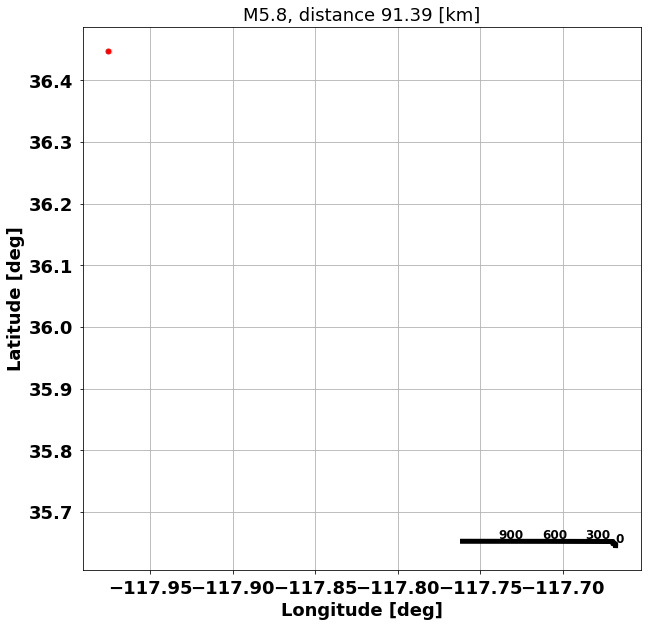

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
# ax.plot(channel_lon,channel_lat,color="k", ls="-", lw=8.0)
ax.plot(channel_lon,channel_lat,color="k", ls="-", lw=5.0,label="DAS channels")
for ii in range(0,channel_index.shape[0],300):
    ax.text(channel_lon[ii],channel_lat[ii],str(ii),fontsize=12,ha='left', va='bottom')
ax.plot(eq_lon, eq_lat, "ro", ms=5)
ax.set_ylabel("Latitude [deg]")
ax.set_xlabel("Longitude [deg]")
ax.set_title("M%s, distance %3.2f [km]"%(eq_mag, np.mean(dist)))
ax.grid()

#### Computing 1D model P- and S-wave traveltimes for this event 

Let's compute the 1D P- and S-wave arrival times using the TauP algorithm. For details see the Obspy documentation (https://docs.obspy.org/packages/obspy.taup.html) and the original reference (http://www.seis.sc.edu/downloads/TauP/taup.pdf)

In [10]:
def compute_azim_dist(lat_c,lon_c,lat_ev,lon_ev):
    (dist_km, az, _) = obspy.geodetics.base.calc_vincenty_inverse(lat_ev,lon_ev,lat_c,lon_c) # A(event) -> B(location)
    dist_deg = obspy.geodetics.base.locations2degrees(lat_ev,lon_ev,lat_c,lon_c)
    return az, dist_deg, dist_km

model = TauPyModel(model="iasp91")
def compute_TT(tele_depth,dist,allPhases=False):
    if allPhases:
        arrivals = model.get_travel_times(source_depth_in_km=tele_depth, distance_in_degree=dist,
                                              receiver_depth_in_km=0.0)
    else:
        arrivals = model.get_travel_times(source_depth_in_km=tele_depth, distance_in_degree=dist,
                                              receiver_depth_in_km=0.0,phase_list=["P", "S"])
    return arrivals

In [11]:
# Computing traveltime for p and s body waves using tau-p code for all channels without considering local structure 
ch_list = np.concatenate((np.arange(0,channel_index.shape[0],50), [channel_index.shape[0]-1]))
P_phase_time_taup = np.zeros(ch_list.shape)
S_phase_time_taup = np.zeros(ch_list.shape)
for idx, ich in enumerate(ch_list):
    _, dist_d,_ = compute_azim_dist(channel_lat[ich], channel_lon[ich], eq_lat, eq_lon)
    arrivals = compute_TT(eq_dep, dist_d)
    # Getting first P and S arrival times
    arr_names =  np.array([arrival.name for arrival in arrivals])
    P_phase_time_taup[idx] = arrivals[np.where(arr_names == "P")[0][0]].time
    S_phase_time_taup[idx] = arrivals[np.where(arr_names == "S")[0][0]].time

The load the downloaded DAS data, data unit is nano strain. Let's try to visualize them and see if we can see the earthquake-induced strain on the telecommunication cable.

In [12]:
startTime, endTime, nTraces = read_PASSCAL_SEGY_headers(file_path, ending='little')
strain, das_time = read_PASSCAL_segy(file_path) # Data shape: n_channel x n_samples, data unit is nano strain
dt = das_time[1] - das_time[0]
# Data is in [num_channels, num_time_samples]
print("Number of channels: %s, number of time samples: %s, Sampling rate: %s [Hz]"%(strain.shape[0],strain.shape[1],1.0/dt))

Number of channels: 1250, number of time samples: 900000, Sampling rate: 250.0 [Hz]


In [13]:
# Downsample the data
# strain, das_time = donwsample_das(strain, das_time, fd=100)
dt = das_time[1] - das_time[0]
print("Number of channels: %s, number of time samples: %s, Sampling rate: %s [Hz]"%(strain.shape[0],strain.shape[1],1.0/dt))
# Creating time axis with respect to earthquake origin
ot = (startTime - eq_date).total_seconds()
das_time_eq = das_time + ot

Number of channels: 1250, number of time samples: 900000, Sampling rate: 250.0 [Hz]


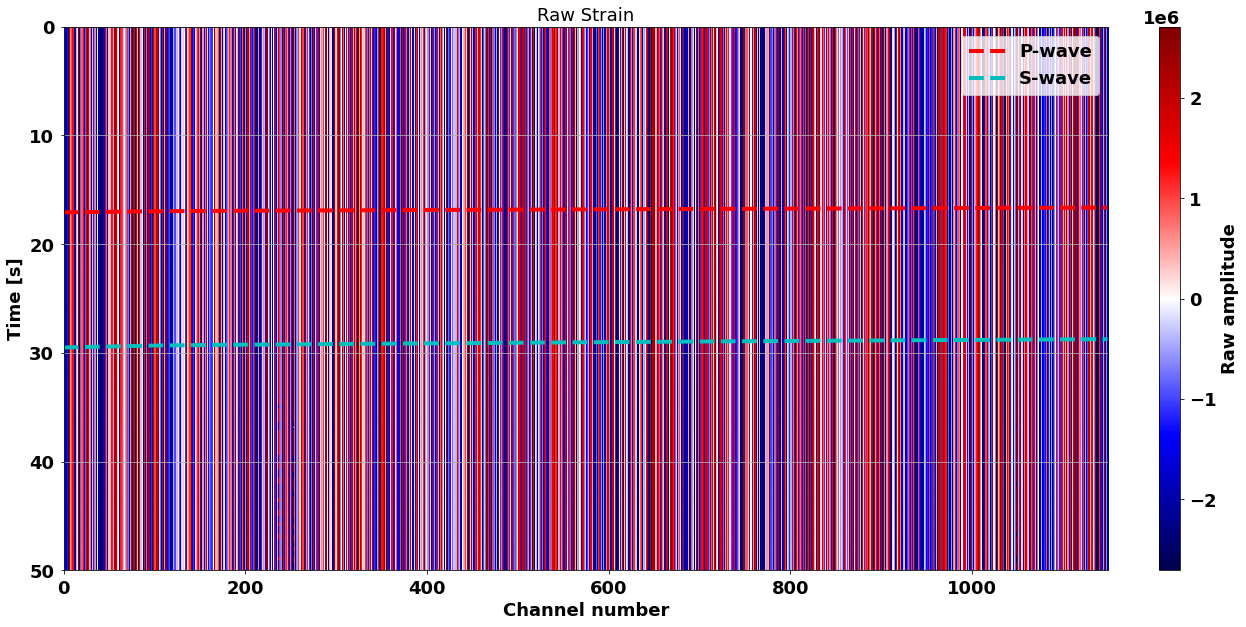

In [14]:
# Show how the raw data looks 
fig, ax1 = show_data(strain[channel_index, ::20], das_time_eq, pclip=98, label="Raw amplitude")
ax1.set_ylim(50.0, 0.0)
ax1.set_title('Raw Strain')
ax1.plot(ch_list,P_phase_time_taup,"r--",lw=4,label="P-wave")
ax1.plot(ch_list,S_phase_time_taup,"c--",lw=4,label="S-wave")
ax1.legend()

Let's high pass filter is often needed to remove the low frequency signals in the DAS data to actually observe earthquake signals.

In [15]:
from scipy.signal import butter, sosfiltfilt
sos = butter(4, 0.5*2*dt, output='sos', btype='high')
strain_filt = sosfiltfilt(sos, strain, axis=1)

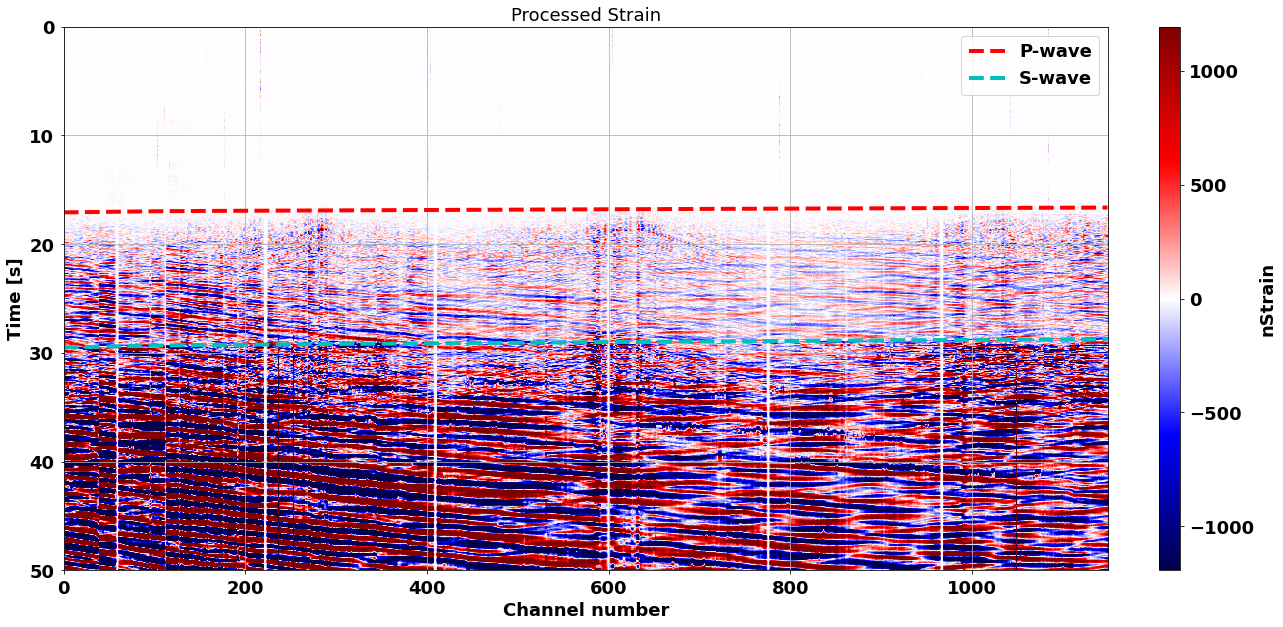

In [16]:
fig, ax2 = show_data(strain_filt[channel_index, ::10], das_time_eq, pclip=99.5)
ax2.set_ylim(50.0, 0.0)
ax2.set_title('Processed Strain')
ax2.plot(ch_list,P_phase_time_taup,"r--",lw=4,label="P-wave")
ax2.plot(ch_list,S_phase_time_taup,"c--",lw=4,label="S-wave")
ax2.legend()

Directly convert the raw strain to strain rate is another way to show the earthquake signal

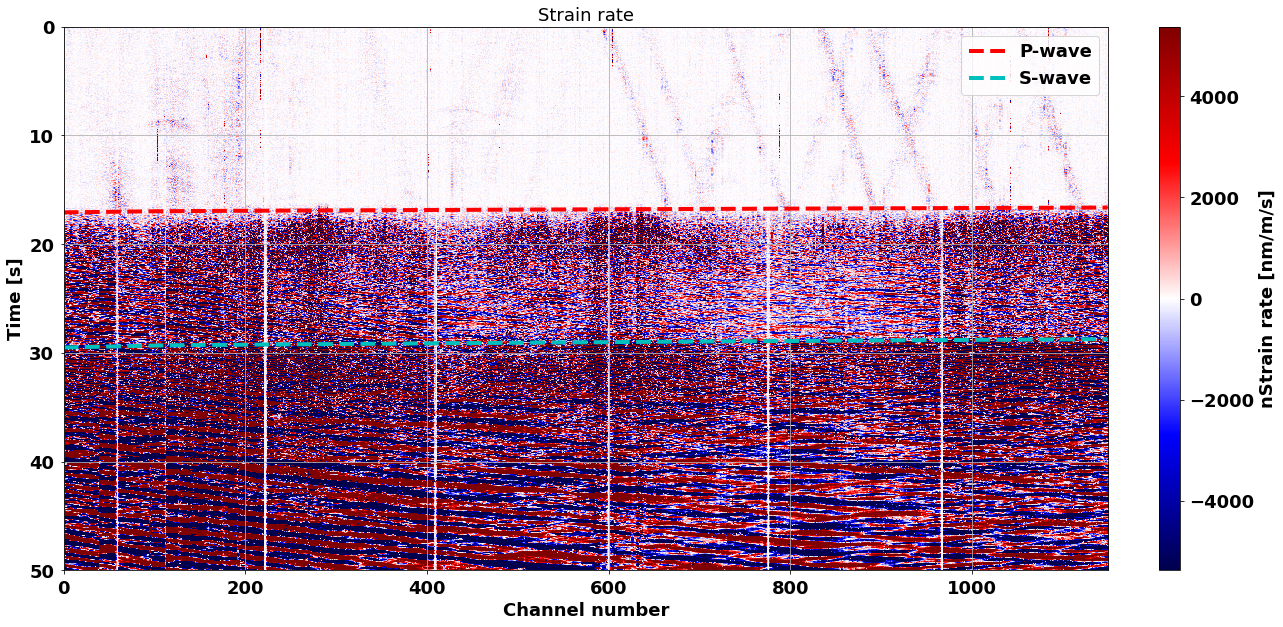

In [63]:
strain_rate = np.gradient(strain, dt, axis=1)
strain_rate_time = das_time[:] + dt/2 + ot

fig, ax3 = show_data(strain_rate[channel_index, ::10], strain_rate_time, pclip=99, label="nStrain rate [nm/m/s]")
ax3.set_title('Strain rate')
ax3.set_ylim(50.0, 0.0)
ax3.set_title('Strain rate')
ax3.plot(ch_list,P_phase_time_taup,"r--",lw=4,label="P-wave")
ax3.plot(ch_list,S_phase_time_taup,"c--",lw=4,label="S-wave")
ax3.legend()

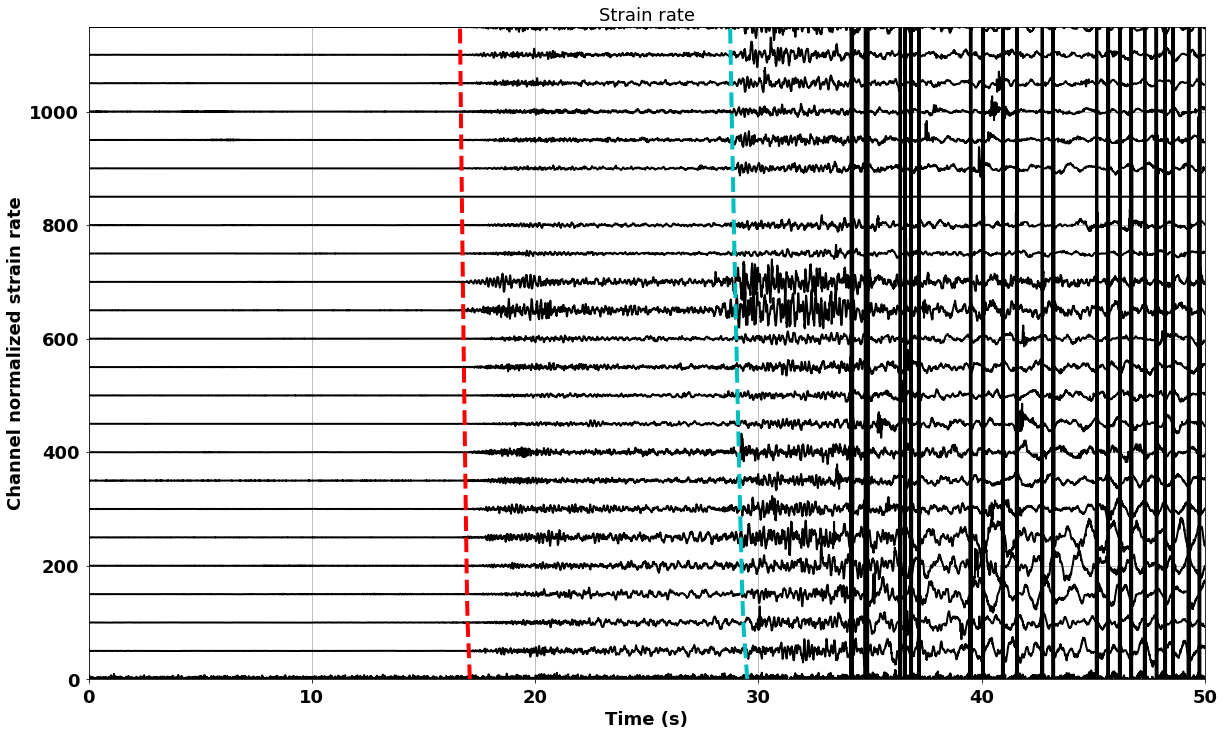

In [22]:
# Show data in time series
fig, ax = plt.subplots(figsize=(20, 12))
gain=5.0e-4
for ii in ch_list:
    ax.plot(strain_rate_time, strain_rate[ii, :]*gain + ii, "k-", linewidth=2.0)

ax.set_ylim(0.0, ch_list[-1])
ax.set_xlim(0, 50.0)
ax.set_xlabel('Time (s)')
ax.plot(P_phase_time_taup,ch_list,"r--",lw=4,label="P-wave")
ax.plot(S_phase_time_taup,ch_list,"c--",lw=4,label="S-wave")
ax.set_ylabel('Channel normalized strain rate')
ax.set_title('Strain rate')
ax.grid()


##### Apply PhaseNet-DAS to obtain traveltime picks

Let's see how PhaseNet-DAS performs on this event. For more details, you can refer to [Zhu et al. (2023)](https://www.nature.com/articles/s41467-023-43355-3)

In [23]:
import DAS_ML

In [ ]:
!pip install torch torchvision h5py pandas fastapi

In [26]:
if DAS_ML.torch.cuda.is_available():
    DAS_ML.preload_model(device="cuda")
else:
    DAS_ML.preload_model(device="cpu")

Downloading: "https://github.com/AI4EPS/models/releases/download/PhaseNet-DAS-v5/model_29.pth" to ./model_29.pth


  0%|          | 0.00/122M [00:00<?, ?B/s]

In [49]:
# Selecting data window for picking
minT = 0.0
maxT = 50.0
strain_rate_time_desamp = strain_rate_time[::2]
strain_rate_desamp = strain_rate[channel_index,::2]
strain_rate_desamp = strain_rate_desamp[:,np.argmin(abs(strain_rate_time_desamp-minT)):np.argmin(abs(strain_rate_time_desamp-maxT))]
strain_rate_time_desamp = strain_rate_time_desamp[np.argmin(abs(strain_rate_time_desamp-minT)):np.argmin(abs(strain_rate_time_desamp-maxT))]

In [56]:
TT_picks = DAS_ML.phasenet_das(strain_rate_desamp, eq_date.strftime(time_format_picking), 0, dt*2)
TT_picks["station_id"] = TT_picks["station_id"].apply(lambda x: int(x))
TT_picks["phase_time_seconds"] = TT_picks["phase_time"].apply(lambda x: (dateutil.parser.parse(x) - eq_date).total_seconds())

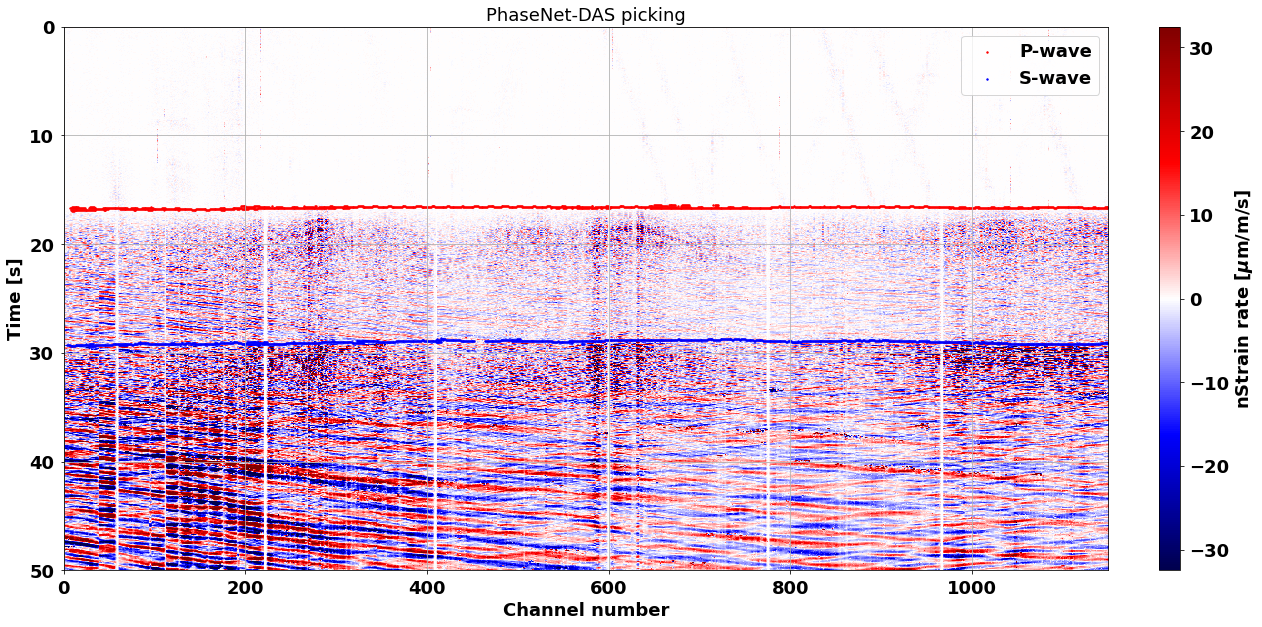

In [66]:
fig, ax3 = show_data(strain_rate_desamp*1e-3, strain_rate_time_desamp, pclip=99, label="nStrain rate [$\mu$m/m/s]")
ax3.set_ylim(50.0, 0.0)
ax3.set_title('PhaseNet-DAS picking')


if TT_picks is not None:
    # Separate the data for P-wave and S-wave
    p_wave = TT_picks[TT_picks["phase_type"] == "P"]
    s_wave = TT_picks[TT_picks["phase_type"] == "S"]
    
    # Plot P-wave picks
    ax3.scatter(p_wave["station_id"], p_wave["phase_time_seconds"], c="red", s=2, label="P-wave")
    
    # Plot S-wave picks
    ax3.scatter(s_wave["station_id"], s_wave["phase_time_seconds"], c="blue", s=2, label="S-wave")
    
    # Add legend
    ax3.legend()
    

##### Computing noise cross-correlation

Let's see how we can turn the seismic noise recorded in the DAS data into virtual active survey. We are going to use fairly basic seismic interferometry. For more details, read the following two important references.

1) Tutorial on seismic interferometry: Part 1 — Basic principles and applications
: https://library.seg.org/doi/full/10.1190/1.3457445

2) Tutorial on seismic interferometry: Part 2 — Underlying theory and new advances: https://library.seg.org/doi/full/10.1190/1.3463440

In [27]:
!pip install torch torchvision

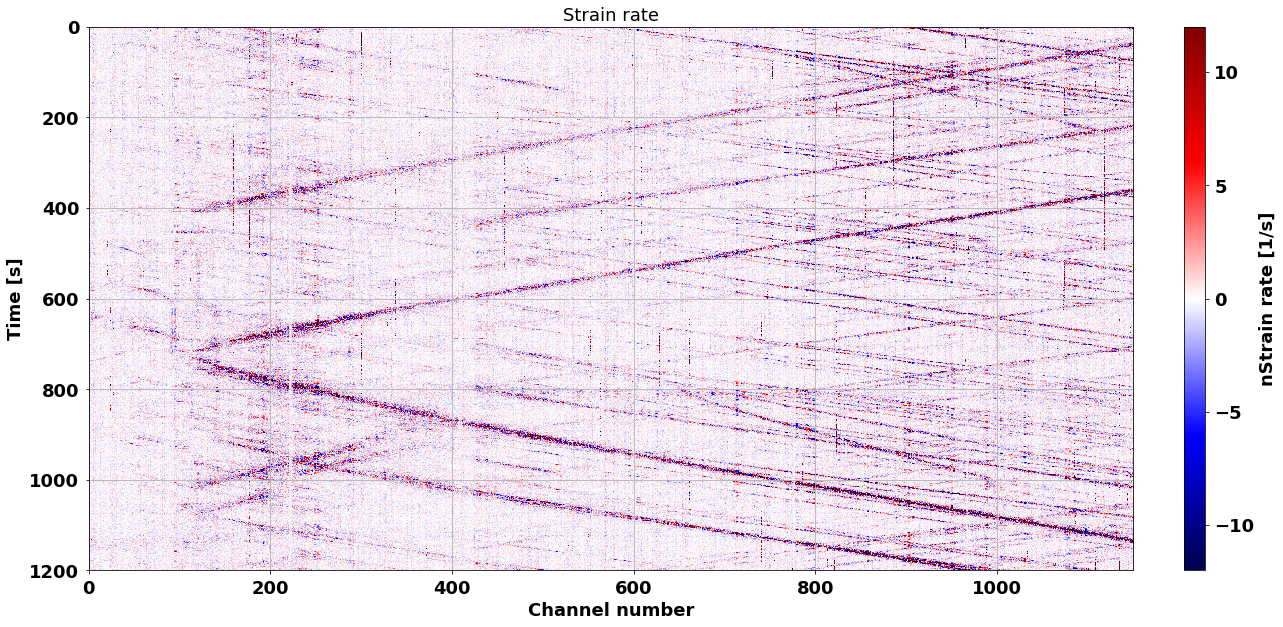

In [21]:
fig, ax3 = show_data(strain_rate[channel_index, ::10], strain_rate_time - ot, pclip=98, label="nStrain rate [1/s]")
ax3.set_title('Strain rate')
_=ax3.set_ylim(1200.0, 0.0)

In [22]:
import torch
from torch import fft

def nextpow2(i):
    n = 1
    while(n < i): n *= 2
    return n

def torch_xcorr(signal_1, signal_2):
    if len(signal_1.shape)<2 | len(signal_2.shape)<2:
        print('input dimension must be ntrace*npts !')
        return 0
    else:
        signal_length = signal_1.shape[-1]
        x_cor_sig_length = signal_length*2 - 1
        fast_length = nextpow2(x_cor_sig_length)

        # The last signal_ndim axes will be transformed
        fft_1 = fft.rfft(signal_1, fast_length, dim=-1)
        fft_2 = fft.rfft(signal_2, fast_length, dim=-1)

        # Take the complex conjugate of one of the spectrums. 
        # Which one you choose depends on domain specific conventions
        fft_multiplied = torch.conj(fft_1) * fft_2

        # back to time domain.
        prelim_correlation = fft.irfft(fft_multiplied, dim=-1)

        # Shift the signal to make it look like a proper crosscorrelation,
        # and transform the output to be purely real
        final_result = torch.roll(prelim_correlation, 
                                  fast_length//2, dims=-1)[:,  fast_length//2-x_cor_sig_length//2:fast_length//2-x_cor_sig_length//2+x_cor_sig_length]
        
        return final_result

In [23]:
def computeCC(data, dt, max_lag, isource=0, ch_buffer_in=-1):
    """Function to compute CC between single DAS channel as virtual source"""
    nch = data.shape[0]
    ch_buffer = data.shape[0] if ch_buffer_in == -1 else ch_buffer_in
    nchunk = int(nch/ch_buffer+1.5) if ch_buffer < nch else 1
    max_lag_npts = int(max_lag/dt)
    cc = np.zeros((nch,max_lag_npts*2+1))
    npts = data.shape[1]
    dataDASsource = torch.from_numpy(data[isource,:npts])
    
    # Processing channel chunks for CC computation
    first_ch = 0
    for ichunk in range(nchunk):
        second_ch = min(first_ch+ch_buffer,nch)
        dataDAS = torch.from_numpy(data[first_ch:second_ch,:].copy()) # DAS data

        cc_all = torch_xcorr(dataDASsource.reshape(1, npts).repeat(dataDAS.shape[0], 1), dataDAS)/npts
        cc[first_ch:second_ch,:] = cc_all[:, npts-max_lag_npts:npts+max_lag_npts+1].numpy()

        first_ch += ch_buffer
    return cc


In [24]:
max_lag = 15.0 # Max lag
max_lag_npts = int(max_lag/dt)
cc = computeCC(strain_rate, dt, max_lag, isource=600)

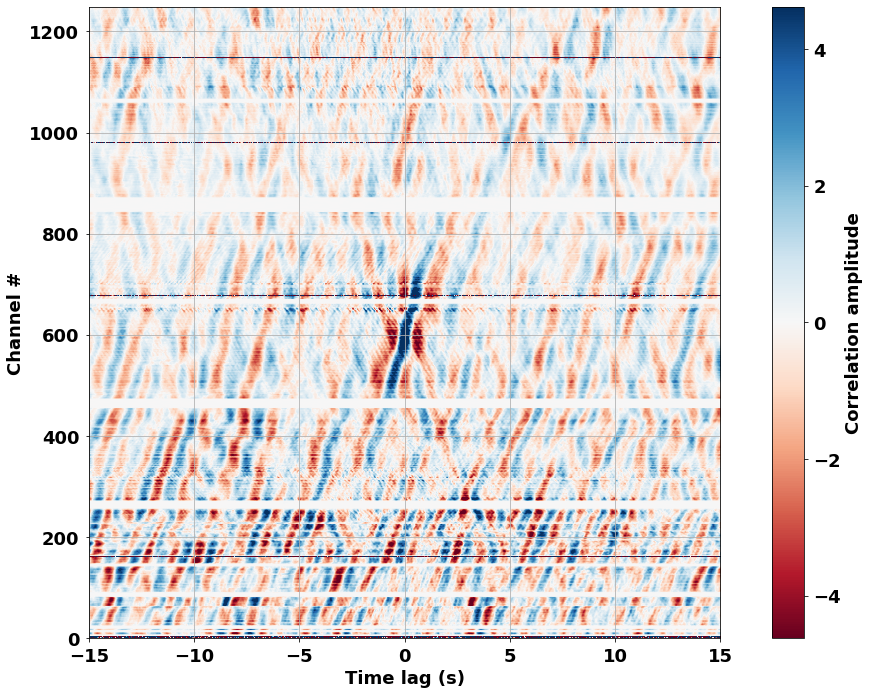

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
t = np.arange(-max_lag_npts, max_lag_npts+1) * dt
nch = strain_rate.shape[0]
y = np.arange(0, nch)
vlim = np.percentile(np.abs(cc), 99)
ratio = (t[-1]-t[0])/(y[-1]-y[0])
im = ax.imshow(cc, cmap=plt.get_cmap("RdBu"), 
               extent=[t[0], t[-1], y[0], y[-1]], vmin=-vlim, 
               vmax=vlim, origin="lower", aspect=ratio)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation amplitude")
ax.grid()

ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Channel #')
ax.set

plt.tight_layout()
plt.show()